### Load line shapefile & merge line segments into correctly ordered LineString

In [1]:
import json
from App.classes.LineBuilder import create_ordered_line

data = json.load(open('shapefiles/gold_northbound/goldJSON.json'))

gold_line = create_ordered_line(data)

### Load Metro Station coordinates & filter for gold line

In [2]:
import geopandas as gpd

stations = gpd.read_file('shapefiles/Metro_Rail_Lines_Stops.shp')
gold_line_stations = stations[stations['MetroLine'] == 'Gold Line']

### Load tracking data & clean (remove dupes, set Datetime as index)

In [3]:
import pandas as pd
from shapely.geometry import Point

tracking_log = pd.read_csv("gold_24hrs.csv")

tracking_log['datetime'] = pd.to_datetime(tracking_log['report_date'] + ' ' + tracking_log['report_time'])
tracking_log = tracking_log.drop_duplicates(subset=['datetime', 'lat', 'lon', 'vehicle_id'])
tracking_log = tracking_log.set_index(pd.DatetimeIndex(tracking_log['datetime']))
tracking_log = tracking_log.drop(['report_date', 'report_time', 'id', 'datetime'], axis=1)
tracking_log = tracking_log.sort_index()

geometry = [Point(xy) for xy in zip(tracking_log.lon, tracking_log.lat)]
tracking_log = gpd.GeoDataFrame(tracking_log[['vehicle_id', 'direction']], crs = {'init': 'epsg:4326'}, geometry = geometry)

### Get station locations as % of line length
Note: stations list is out of date - missing last 2 or 3 stations (Azusa, APU etc.)
Approximate positions are shown to highlight inaccuracies in converting from coordinates to relative positions and back - we need to dig more into this, see if it is due to incorrect projection mapping.

#### Relative Positions
This is the percentage of the distance along the line that station X occurs, from the start of the line (Atlantic Station is the first station at relative position = 0.002738)

In [4]:
for index, station in gold_line_stations.iterrows():
    relative_position = gold_line.project(station.geometry) / gold_line.length
    absolute_position = gold_line.interpolate(relative_position * gold_line.length)
    gold_line_stations.loc[index, "relative_position"] = relative_position
    gold_line_stations.loc[index, "approx_lon"] = absolute_position.x
    gold_line_stations.loc[index, "approx_lat"] = absolute_position.y

gold_line_stations_sorted = gold_line_stations.sort_values('relative_position').reset_index().drop(['index'], axis=1)
gold_line_stations_sorted[['Station','relative_position','approx_lat','approx_lon','geometry']]

/home/cts/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/cts/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Station,relative_position,approx_lat,approx_lon,geometry
0,Atlantic,0.002738,34.033430,-118.154480,POINT (-118.1544809237101 34.03340293076384)
1,East LA Civic Center,0.015783,34.033395,-118.161219,POINT (-118.1612185574534 34.03336897495151)
2,Maravilla,0.029205,34.033333,-118.168152,POINT (-118.168151663007 34.03330470448532)
3,Indiana,0.077266,34.034306,-118.192130,POINT (-118.1921945374667 34.03430462952462)
4,Soto,0.117932,34.043794,-118.210054,POINT (-118.2100727563455 34.04375158063937)
5,Mariachi Plaza / Boyle Heights,0.137946,34.047327,-118.219656,POINT (-118.2196601269608 34.0472199733497)
6,Pico / Aliso,0.150154,34.047669,-118.225951,POINT (-118.2259524962327 34.047638710262)
7,Little Tokyo / Arts District,0.175222,34.050102,-118.237844,POINT (-118.2379130244296 34.05010491317475)
8,Union Station,0.191215,34.056050,-118.234697,POINT (-118.2347711717361 34.0560663176562)
9,Chinatown,0.209281,34.063840,-118.235778,POINT (-118.2358526287251 34.06386540877716)


### select small window of tracked trains for analysis

In [5]:
start_date = '08/29/18 11:02:00'
end_date = '08/29/18 11:05:00'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

analysis_window = tracking_log[start_date:end_date]

for index, train in analysis_window.iterrows():
    relative_position = gold_line.project(train.geometry) / gold_line.length
    analysis_window.loc[index, "relative_position"] = relative_position
    

/home/cts/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/cts/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Compare tracked trains to stations to find the next station for each train
Assuming direction 0 is northbound and 180 is southbound

In [26]:
def find_next_stop(relative_pos_of_train, direction):
    reverse = direction / 180
    
    for index, station in gold_line_stations_sorted.iterrows():        
        if relative_pos_of_train < station.relative_position:
            stop_index = max(index - reverse, 0)
            return gold_line_stations_sorted.loc[stop_index]

for index, train in analysis_window.iterrows():
    if train.relative_position < 0.619018:
        next_stop = find_next_stop(train.relative_position, train.direction)
        analysis_window.loc[index:index, 'next_stop'] = next_stop['Station']
    else:
        analysis_window.loc[index:index, 'next_stop'] = 'Missing Station'
        
analysis_window[['vehicle_id', 'relative_position', 'next_stop']]

/home/cts/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,vehicle_id,relative_position,next_stop
datetime,,,
2018-08-29 11:02:03,408,0.517066,Memorial Park
2018-08-29 11:02:14,404,0.002709,Atlantic
2018-08-29 11:02:24,407,0.412080,South Pasadena
2018-08-29 11:02:35,401,0.634175,Missing Station
2018-08-29 11:02:35,452,0.634175,Missing Station
2018-08-29 11:02:45,403,0.184947,Union Station
2018-08-29 11:02:54,406,0.915327,Missing Station
2018-08-29 11:02:54,409,0.915327,Missing Station
2018-08-29 11:02:54,454,0.915327,Missing Station


### Vehicles and Stations plotted:

The "Missing Station" stops above refer to the red dots below that fall beyond (east of) Sierra Madre Station - my gold line station data is missing the final 3 (?) stops.

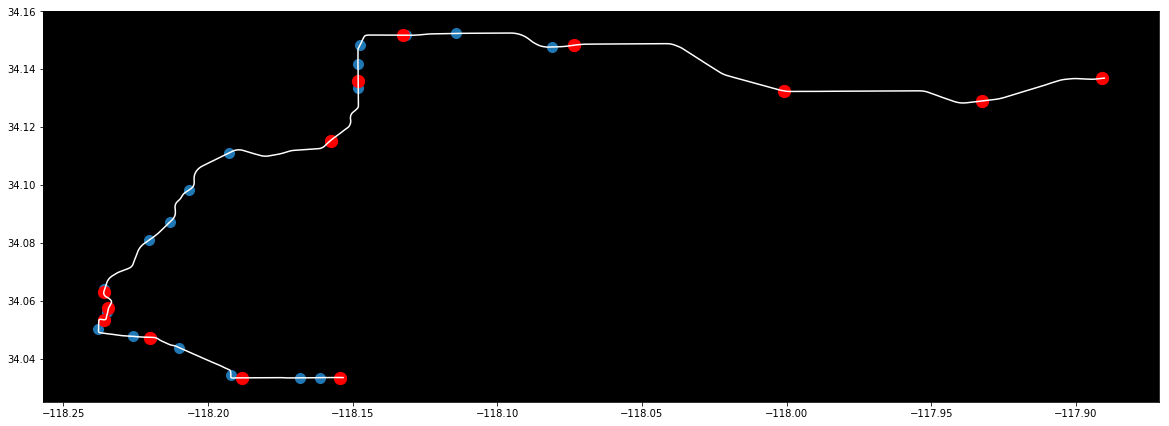

In [31]:
gold_line_plot = gpd.GeoSeries(gold_line)
gold_line_plot = gold_line_plot.plot(figsize=(20, 20), color='white')
gold_line_plot.set_facecolor("black")

gold_line_stations.plot(ax=gold_line_plot, markersize=100)
analysis_window.plot(ax=gold_line_plot, markersize=150, color="#ff0000")